## Import needed packages and scripts


In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd

# Display settings for Jupyter Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Importing custom utility functions
import utils

# Importing Lstchain packages
from traitlets.config.loader import Config
from astropy.coordinates import SkyCoord
from lstchain.io.config import get_standard_config
from ctapipe.io import read_table

# Some configurations

In [2]:
# Source specifications
source_name = "crab"

# Run numbers to analyze
run_numbers = [10880]  # Specify the run numbers you are interested in
# Example: run_numbers = [6172, 6242, 6194, 6193, 15337, 15272, 15339, 15340]

# Number of subruns to analyze per run
subruns_num = 2  # Specify the number of subruns you want to analyze, set subruns_num = None to analyze all subruns

# Paths to data and results

In [3]:
# Root path of this script
root = "/fefs/aswg/workspace/juan.jimenez/lst_pipeline/"
# Path to store the configuration file we are going to use
config_file = root + "config/standard_config.json"
# Data main directory
root_data = root + f"../data/tests/{source_name}/"

# STANDARD paths ---------
# DL1 data root
dl1_root = "/fefs/aswg/data/real/DL1/*/v0.*/tailcut84/"
# RFs root main directory
rfs_root = "/fefs/aswg/data/models/AllSky/20230901_v0.10.4_allsky_base_prod/"
# MCs dl2 main directory
mcs_root = "/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/"

# Directories for the data
dir_dl1b = root_data + "dl1b/"
dir_dl2  = root_data + "dl2/"
dir_dl2m = root_data + "dl2_merged/"
dir_dl3  = root_data + "dl3/"
dir_irfs = root_data + "irfs/"

# Creating the directories in case they don't exist
for path in [os.path.dirname(config_file), dir_dl1b, dir_dl2, dir_dl2m, dir_dl3, dir_irfs]:
    if not os.path.exists(path):
        os.makedirs(os.path.join(path), exist_ok=True)

# Opening and storing configuration file

In [4]:
config_dict = get_standard_config()
# print(config_dict)

#-------------------
# Changes in the configuration should be done here

# We select the heuristic flatfield option in the standard configuration
config_dict["source_config"]["LSTEventSource"]["use_flatfield_heuristic"] = True

#-------------------

with open(config_file, 'w') as json_file:
    json.dump(config_dict, json_file)

# Finding the files that interest us
#### Extracting dl1 files and dl1 datachecks

In [5]:
# Getting coordinates of source
source_coords = SkyCoord.from_name(source_name)

dict_source = {
    "name"   : source_name,
    "coords" : source_coords,
    "ra"     : source_coords.ra.deg  * u.deg, # ra in degrees
    "dec"    : source_coords.dec.deg * u.deg, # dec in degrees
}

# We create a empty dictionary to store all the information needed inside
DICT = {}
for run in run_numbers:
    DICT[run] = {
        "run_num" : run
    }

DICT = utils.add_dl1_paths_to_dict(DICT, dl1_root)
DICT = utils.add_dl1_paths_to_dict(DICT, dl1_root, dchecking=True)


Adding dl1  data to dictionary...
--> /fefs/aswg/data/real/DL1/20221119/v0.9/tailcut84/dl1_LST-1.Run10880.h5 (SELECTED)
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary...
--> /fefs/aswg/data/real/DL1/20221119/v0.9/tailcut84/datacheck_dl1_LST-1.Run10880.h5 (SELECTED)
...Finished adding dl1 data to dictionary


#### Then we read the observations information and also the selected nodes for MC and RFs and we add it to the DICT

In [6]:
%%time
for run in run_numbers:

    tab = read_table(DICT[run]["dchecks"]["runwise"], "/dl1datacheck/cosmics")
    
    # reading the variables
    _zd,     _az       = 90 - np.rad2deg(np.array(tab["mean_alt_tel"])), np.rad2deg(np.array(tab["mean_az_tel"]))
    _t_start, _t_elapsed = tab["dragon_time"][0][0],                       np.array(tab["elapsed_time"])
    
    DICT[run]["time"] = {
        "tstart"   : _t_start,            # datetime object
        "telapsed" : np.sum(_t_elapsed),  # s
        "srunwise" : {
            "telapsed" : _t_elapsed,      # s      
        },
    }
    DICT[run]["pointing"] = {
        "zd" : np.mean(_zd),  # deg
        "az" : np.mean(_az),  # deg
        "srunwise" : {
            "zd" : _zd,       # deg
            "az" : _az,       # deg
        },
    }
    
# then we also select the RFs and MC files looking at the nodes available
DICT, dict_nodes = utils.add_mc_and_rfs_nodes(DICT, rfs_root, mcs_root, dict_source)

CPU times: user 134 ms, sys: 40.3 ms, total: 175 ms
Wall time: 173 ms


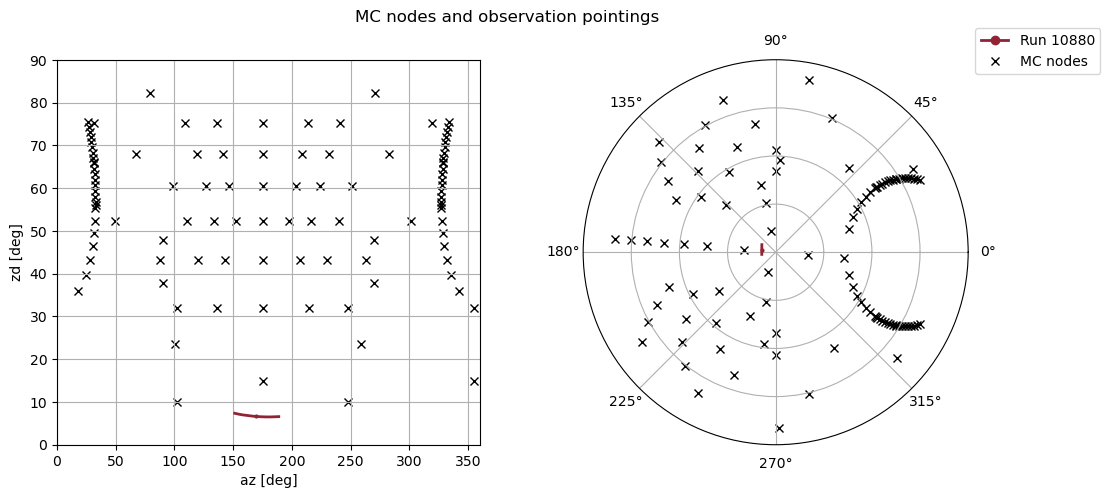

In [7]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("MC nodes and observation pointings")
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="polar")

colors = [np.random.rand(3) for _ in range(len(run_numbers))] # random color for each run
for method, ax in zip([np.array, np.deg2rad], [ax1, ax2]):
    for i, run in enumerate(run_numbers):
        
        ax.plot(method(DICT[run]["pointing"]["srunwise"]["az"]), DICT[run]["pointing"]["srunwise"]["zd"], marker="",  color=colors[i], ls="-", lw=2)
        ax.plot(method(DICT[run]["pointing"]["az"]),             DICT[run]["pointing"]["zd"],             marker="o", color=colors[i], ls="",  ms=2)
 
        ax.plot([], [], marker="o", ls="-", lw=2, color=colors[i], label=f"Run {run}")
    ax.plot(method(dict_nodes["pointing"]["az"]), dict_nodes["pointing"]["zd"], marker="x", ls="", color="k", zorder=-10, label="MC nodes")

for ax in [ax1, ax2]:
    ax.grid(True, zorder=-100)
    ax.set_ylim(0, 90)
ax1.set_xlim(0, 360)
ax2.legend(loc="upper left", bbox_to_anchor=(1, 1.1))
ax2.set_yticks([22.5, 45, 67.5], [])
ax1.set_xlabel("az [deg]")
ax1.set_ylabel("zd [deg]")
plt.show()

# DL1a to DL1b

# <span style="color:red">Bug: OSError: Unsupported version of subarray table: 1.0 (fixed adding the telescope geometry manually)</span>

In [8]:
%%time
for ir, run in enumerate(DICT.keys()):

    dir_run = dir_dl1b + f"{run:05}" + "/"
    sruns = [int(path.split(".")[-2]) for path in DICT[run]["dl1a"]["srunwise"]]
    DICT[run]["dl1b"] = {"srunwise" : []}
    
    # Create a folder for each run
    if not os.path.exists(dir_run):
        os.makedirs(os.path.join(dir_run), exist_ok=True)

    for i, srun in enumerate(sruns[:subruns_num]):

        input_fname  = DICT[run]["dl1a"]["srunwise"][i]
        output_fname = dir_run + f"dl1_LST-1.Run{run:05}.{srun:04}.h5"

        print(f"\nComputing dl1b Run {run:5} Subrun {srun:04} - {i/len(sruns)*100:3.1f}% sruns {ir+1}/{len(DICT.keys())} runs")
        print(f"--> {output_fname}\n")

        !lstchain_dl1ab \
          --input-file $input_fname \
          --output-file $output_fname \
          --config $config_file \
          --no-image

        DICT[run]["dl1b"]["srunwise"].append(output_fname)


Computing dl1b Run 10880 Subrun 0000 - 0.0% sruns 1/1 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl1b/10880/dl1_LST-1.Run10880.0000.h5

Output file /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl1b/10880/dl1_LST-1.Run10880.0000.h5 already exists

Computing dl1b Run 10880 Subrun 0001 - 0.6% sruns 1/1 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl1b/10880/dl1_LST-1.Run10880.0001.h5

Output file /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl1b/10880/dl1_LST-1.Run10880.0001.h5 already exists
CPU times: user 213 ms, sys: 98.1 ms, total: 311 ms
Wall time: 16.4 s


# DL1b to DL2

In [9]:
%%time
for ir, run in enumerate(DICT.keys()):

    dir_run = dir_dl2 + f"{run:05}" + "/"
    sruns = [int(path.split(".")[-2]) for path in DICT[run]["dl1a"]["srunwise"]]
    DICT[run]["dl2"] = {"srunwise" : []}
    
    # Create a folder for each run
    if not os.path.exists(dir_run):
        os.makedirs(os.path.join(dir_run), exist_ok=True)
    
    for i, srun in enumerate(sruns[:subruns_num]):

        input_fname  = DICT[run]["dl1b"]["srunwise"][i]
        output_fname = dir_run + input_fname.split("/")[-1].replace("dl1", "dl2", 1)
        rf_node      = DICT[run]["simulations"]["rf"]

        # Check if the file exists and delete if exists (may be empty or half filled)
        if os.path.exists(output_fname):
            print(f"File already exists, deleting and re-computing: {output_fname}")
            os.remove(output_fname)

        print(f"\nComputing dl1b Run {run:5} Subrun {srun:04} - {i/len(sruns)*100:3.1f}% sruns {ir+1}/{len(DICT.keys())} runs")
        print(f"--> {output_fname}\n")

        !lstchain_dl1_to_dl2 \
          --input-files $input_fname \
          --path-models $rf_node \
          --output-dir $dir_run \
          --config $config_file

        DICT[run]["dl2"]["srunwise"].append(output_fname)


Computing dl1b Run 10880 Subrun 0000 - 0.0% sruns 1/1 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl2/10880/dl2_LST-1.Run10880.0000.h5


Computing dl1b Run 10880 Subrun 0001 - 0.6% sruns 1/1 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl2/10880/dl2_LST-1.Run10880.0001.h5

CPU times: user 1.37 ms, sys: 0 ns, total: 1.37 ms
Wall time: 1.05 ms


# DL2 merging run-wise

In [10]:
%%time
for ir, run in enumerate(DICT.keys()):

    dir_run = dir_dl2 + f"{run:05}" + "/"
    output_fname = dir_dl2m + f"dl2_LST-1.Run{run:05}.h5"
    
    !lstchain_merge_hdf5_files \
      --input-dir $dir_run \
      --output-file $output_fname \
      --run-number $run \
      --no-image
    
    DICT[run]["dl2"]["runwise"] = output_fname

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.53it/s]
CPU times: user 133 ms, sys: 35.6 ms, total: 168 ms
Wall time: 9.29 s


# MCs to IRFs
# <span style="color:red">Version of pyirf needed, at least v0.10</span>

In [17]:
%%time
# Already computed IRFs
computed_irfs = glob.glob(dir_irfs + "*")

for ir, run in enumerate(DICT.keys()):
    
    input_mc = DICT[run]["simulations"]["mc"]

    output_irf = dir_irfs + "irf_{}_{}.fits.gz".format(input_mc.split("/")[-3], input_mc.split("/")[-2])

    # we don't compute the IRF if it has been already done
    if output_irf not in computed_irfs:
        
        print(f"\nComputing IRF for Run {run:5}, {ir+1}/{len(DICT.keys())} runs")
        print(f"--> {output_irf}\n")
        
        !lstchain_create_irf_files \
          --input-gamma-dl2 $input_mc \
          --output-irf-file $output_irf \
          --point-like \
          --energy-dependent-gh \
          --energy-dependent-theta \
          --overwrite
    else:
        print("\nIRF {}_{} already computed\n".format(input_mc.split("/")[-3], input_mc.split("/")[-2]))
    DICT[run]["irf"] = output_irf


Computing IRF for Run 10880, 1/1 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/irfs/irf_dec_2276_node_theta_70.732_az_330.659_.fits.gz

/fefs/aswg/workspace/juan.jimenez/softs/cta-lstchain/lstchain/reco/utils.py:536: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
CPU times: user 262 ms, sys: 79.5 ms, total: 341 ms
Wall time: 18.8 s


# DL2 to DL3

In [19]:
%%time
ra_str  = "{}".format(dict_source["ra"]).replace(" ", "")
dec_str = "{}".format(dict_source["dec"]).replace(" ", "")

for ir, run in enumerate(DICT.keys()):

    # dir_run = dir_dl3 + f"{run:05}" + "/"    
    dl2_fname = DICT[run]["dl2"]["runwise"]

    output_dl3 = dir_dl3 + f"dl3_LST-1.Run{run:05}.fits"
    
    print(f"\nConverting dl2 for {run:5}, {ir+1}/{len(DICT.keys())} runs")
    print(f"--> {output_dl3}\n")
    
    !lstchain_create_dl3_file \
      --input-dl2 $dl2_fname \
      --input-irf-path $dir_irfs \
      --output-dl3-path $dir_dl3 \
      --source-name $source_name \
      --source-ra $ra_str \
      --source-dec $dec_str \
      --config $config_file \
      --overwrite

    DICT[run]["dl3"] = output_dl3


Converting dl2 for 10880, 1/1 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl3/dl3_LST-1.Run10880.fits

/fefs/aswg/workspace/juan.jimenez/softs/cta-lstchain/lstchain/reco/utils.py:536: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
CPU times: user 141 ms, sys: 50.6 ms, total: 192 ms
Wall time: 10.4 s


## Add DL3 index files

In [23]:
print(f"All dl3 files created 100%\n\n\nCreating index files...")

# Creating the index file
!lstchain_create_dl3_index_files \
--input-dl3-dir $dir_dl3 \
--file-pattern 'dl3*.fits' \
--overwrite

print(f"\nFinished with the dl3 process")

All dl3 files created 100%


Creating index files...
2023-12-22 19:58:58,339 ERROR [lstchain.high_level.hdu_table] (hdu_table.create_hdu_index_hdu): Run 10880 does not contain HDU BACKGROUND
2023-12-22 19:58:58,339 ERROR [lstchain.high_level.hdu_table] (hdu_table.create_hdu_index_hdu): Run 10880 does not contain HDU PSF
Finished with the dl3 process
